In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from torch.distributions import normal

import time

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# libraries from bliss 
from bliss.models import encoder
from bliss.datasets import sdss

# utils unique to this experiment
import sys
sys.path.insert(0, './utils')

from encoder_lib import MLPEncoder
from dataset_lib import CenteredStarsData, trim_psf
from which_device import device


print(device)


cuda:4


# Create dataset

### The psf

In [2]:
sdss_dir = '/home/runingli/astronomy/celeste/data/sdss/'
psf_file = sdss_dir + '/94/1/12/psField-000094-1-0012.fits'

In [11]:
sdss_psf = sdss.SdssPSF(psf_file, [2])
psf = sdss_psf.psf_at_points(0, 0., 0.)

# convert to torch tensor
psf = torch.Tensor(psf).to(device)

# trim the psf
slen = 3
psf = trim_psf(psf, slen)

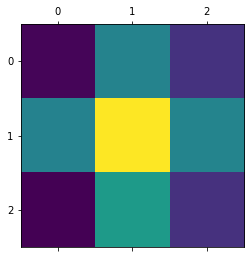

In [12]:
%matplotlib inline

plt.matshow(psf.cpu().numpy())

### the dataset: just centered stars

In [13]:
n_images = 20000
star_data = CenteredStarsData(psf, 
                              n_images = n_images)

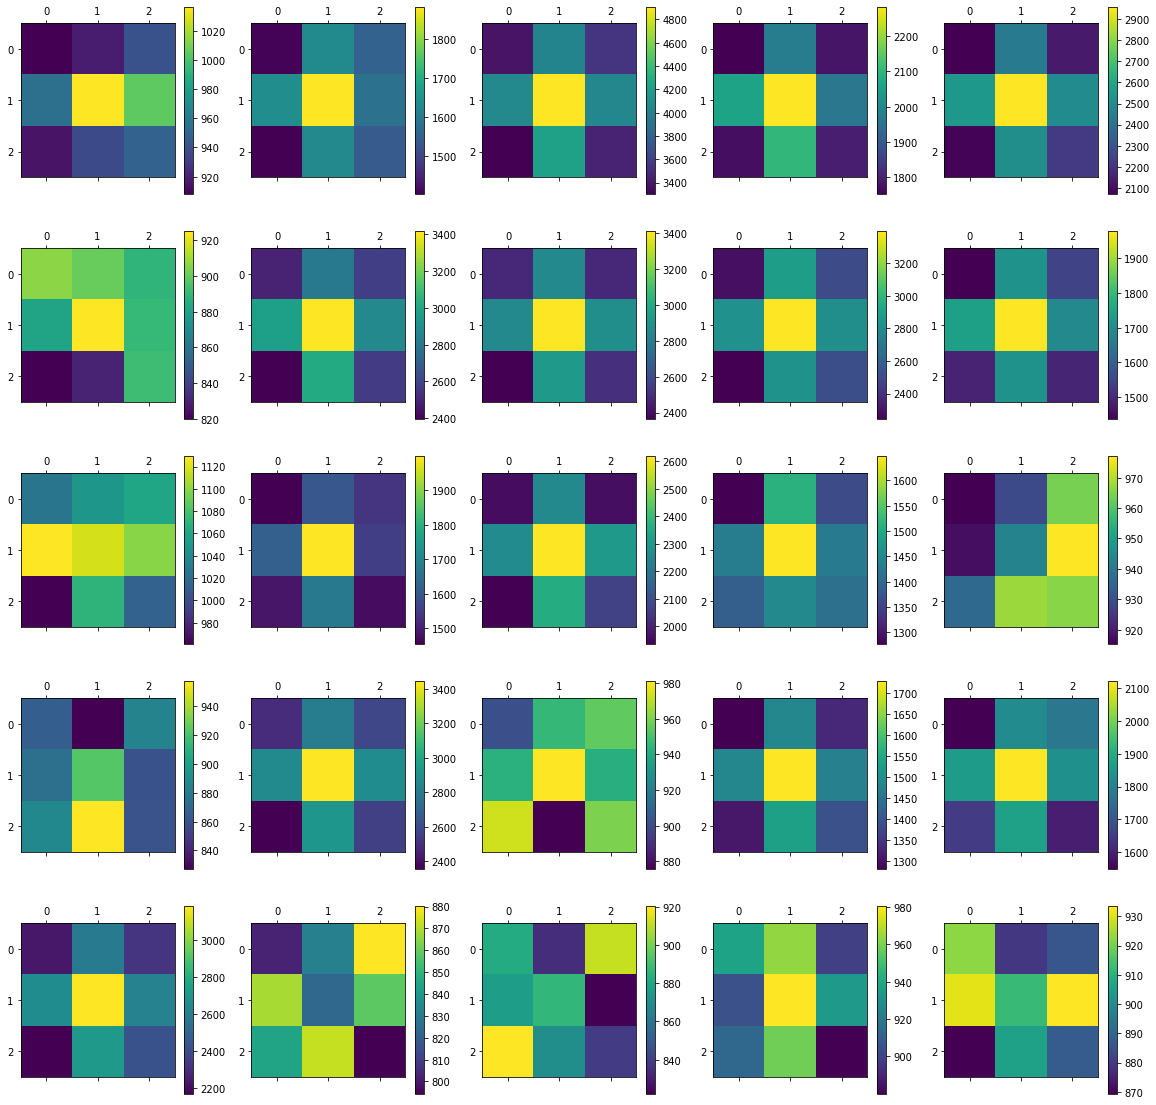

In [14]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))

for i in range(25): 
        
    x0 = i // 5
    x1 = i % 5
    
    image = star_data[i]['image']
    
    im = ax[x0, x1].matshow(image[0].cpu())
    
    fig.colorbar(im, ax = ax[x0, x1])


# Define neural network

In [15]:
network = MLPEncoder(slen = slen).to(device)
network

MLPEncoder(
  (fc1): Linear(in_features=9, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)

# Define dataset

In [16]:
batch_size = 1000
data_loader = DataLoader(star_data, 
                         batch_size=batch_size)

# Define loss

### Sleep phase loss: KL(p, q), with log-normal distribution

In [17]:
def klpq_logspace(network, batch): 
    
    images = batch['image']
    fluxes = batch['flux'].squeeze()
    
    logflux = torch.log(fluxes)
    
    mean, sd = network(images)
    
    # setting sd
    sd = sd * 0. + 1.
    
    norm = normal.Normal(loc = mean, scale = sd)
    
    return - norm.log_prob(logflux)

# Train 

In [18]:
for _, batch in enumerate(data_loader):
    break

In [19]:
# initial loss 
loss = klpq_logspace(network, batch).mean()
print('initial loss: {}'.format(loss))

initial loss: 396111.0


In [20]:
optimizer = optim.Adam(network.parameters())

In [21]:
n_epochs = 60

In [ ]:
network.train()
t0 = time.time() 

for epoch in range(n_epochs): 
    
    avg_loss = 0.
    
    for _, batch in enumerate(data_loader):
        loss = klpq_logspace(network, batch).mean()
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        avg_loss += loss 
        
    print('epoch [{}]. loss = {}'.format(epoch, avg_loss / len(data_loader)))

print('done. Elapsed {:.03f}sec'.format(time.time() - t0))

epoch [0]. loss = 77222.125
epoch [1]. loss = 5938.005859375
epoch [2]. loss = 752.8566284179688
epoch [3]. loss = 180.14794921875


In [1]:
# final loss
network.eval()
loss = klpq_logspace(network, batch).mean()
print('final loss: {}'.format(loss))

NameError: name 'network' is not defined

In [ ]:
true_fluxes = batch['flux']

means, sd = network(batch['image'])

In [ ]:
plt.hist(sd.detach().cpu().numpy())

In [ ]:
plt.scatter(np.log(true_fluxes.cpu()), 
            means.detach().cpu())

In [ ]:
true_fluxes.shape